<center><img src="https://media-exp1.licdn.com/dms/image/C4E22AQEbIXZiRVkJPQ/feedshare-shrink_2048_1536/0?e=1605139200&v=beta&t=opmJLG_veDflQesF9uJvIhSXbmwPY3DGSlbZo1v-w2k" width="1000"></center>

# SDC Certified Program in Python for Data Science

## Tema 7: Regresión Logística
### Caso Practico: conjunto de datos de reclamos de señal de telefonía

### Prof. Manuel Sigüeñas, M.Sc.(c) 

[Perfil](https://socialdata-peru.com/learning/teacher2.php)

### Prof. Lenguajes de Programación para Ciencia de Datos / Agile Data Scientists / SCRUMStudy Certified Trainer


[msiguenas@socialdata-peru.com](msiguenas@socialdata-peru.com)

1. [Importar y preprocesar la data](#part1) 
2. [Construir la data de en entrenamiento y de prueba (test)](#part2)
3. [Balanceo de datos](#part3)
4. [Regresión Logística-entrenamiento](#part4) 

In [26]:
from IPython.display import Image
%matplotlib inline


____
[Ir a inicio](#beginning)

El objetivo es construir un modelo para predecir si en cierta zona habrá o no habrá reclamo de clientes (indicentes). Para ello cada registro contiene información de:

**RSRP:** Nivel de Señal medido en dBm. Generalmente una buena señal es de -70 dBm, y luego se va degradando hacia valores muy malos por debajo de -115 dBm. Mientras más negativo es el valor peor es la señal. Con respecto a este valor, es importante señalar que los **valores perdidos** fueron codificados como **0**.

**Redireccion:** Si una red 4G hay redirecciones o transiciones hacia 3G es un indicativo de que hay problemas en la señal. Esta variable indica la cantidad de conexiones que se van a 3G.

**CQI:** Indicador de la calidad del enlace de radiofrecuencia. Los valores van de 1 a 15. 6 o 7 son valores malos, a partir de 12 hay una buena calidad. A menor calidad hay propensión de mayor reclamos.

**Incidentes:** Variable objetivo, que indica la cantidad de reclamos que existen en la zona. Podemos recodificar 1: Reclamo, 0: No Reclamo. Hay valores 0, nulos, vacíos que habría que limpiar. Adicionalmente hay pocos indicentes (Reclamos) con relación a la cantidad de registros, por lo que habría que como tarea previa (preprocesamiento) realizar un **balanceo de datos**.

- **Paquetes necesarios**:

In [1]:
#Después de la instalación exitosa, la extensión watermark se puede cargar a través de:
%reload_ext watermark
%watermark -a "Social Data Consulting" -u -d -p numpy,pandas,scipy,matplotlib,sklearn,statsmodels,imblearn,os

Social Data Consulting 
last updated: 2020-06-03 

numpy 1.18.1
pandas 1.0.1
scipy 1.4.1
matplotlib 3.1.3
sklearn 0.21.3
statsmodels 0.11.0
imblearn 0.6.0.dev0
os unknown


In [8]:
#!pip install imbalanced-learn

In [2]:
#pip Upgrade imbalanced-learn

In [9]:
#pip install --user git+https://github.com/scikit-learn-contrib/imbalanced-learn.git

In [3]:
# imbalanced-learn requiere los siguientes paquetes:
import numpy as np
import scipy
import statsmodels.api as sm
from imblearn.combine import SMOTETomek
#from imblearn.ensemble import BalancedBaggingClassifier

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

In [5]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.feature_selection import RFE
from pylab import rcParams

____
[Ir a inicio](#beginning)

<a id='part1'></a>
## Importar y preprocesar la data

In [6]:
os.getcwd() #esto te permite conocer el directorio actual

'C:\\Users\\SOCIAL DATA'

In [7]:
os.chdir("D:/Python/2. Nivel II/7/datos") # la ruta absoluta
#una vez ubicado en el directorio adecuado puedes ejecutar el comando 

In [8]:
FileCSV="Grid v1.csv"
entel=pd.read_csv(FileCSV)
entel.head(n=5)

C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3063: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,Description,Col_Name,Row_Name,rsrp,incidentes,redireccion,best_server,cqi
0,A1,A,1,0.0,0,0.0,NaN,0.0
1,A2,A,2,0.0,0,0.0,NaN,0.0
2,A3,A,3,0.0,0,0.0,NaN,0.0
3,A4,A,4,0.0,0,0.0,NaN,0.0
4,A5,A,5,0.0,0,0.0,NaN,0.0


In [9]:
entel.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 197640 entries, 0 to 197639
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   Description  197640 non-null  object 
 1   Col_Name     197640 non-null  object 
 2   Row_Name     197640 non-null  int64  
 3   rsrp         197640 non-null  float64
 4   incidentes   197640 non-null  int64  
 5   redireccion  197640 non-null  float64
 6   best_server  23318 non-null   object 
 7   cqi          197640 non-null  float64
dtypes: float64(3), int64(2), object(3)
memory usage: 12.1+ MB


In [10]:
print(entel.shape)

(197640, 8)


In [11]:
entel = entel.loc[(entel['rsrp'] < 0)]
print(entel.shape)

(23103, 8)


In [12]:
print(pd.value_counts(entel['incidentes'], sort = True))

0    21601
1     1279
2      167
3       41
4       11
6        2
7        1
5        1
Name: incidentes, dtype: int64


In [13]:
entel.dtypes

Description     object
Col_Name        object
Row_Name         int64
rsrp           float64
incidentes       int64
redireccion    float64
best_server     object
cqi            float64
dtype: object

In [14]:
#código para cambiar formato de datos
#entel['incidentes'] = entel['incidentes'].astype(np.float64) 

In [14]:
entel['incidentes']=entel["incidentes"].replace([2, 3, 4, 5, 6, 7],1)

In [15]:
print(pd.value_counts(entel['incidentes'], sort = True))

0    21601
1     1502
Name: incidentes, dtype: int64


In [15]:
entel = entel[["rsrp", "redireccion", "cqi", "incidentes"]]

In [16]:
entel.head(10)

,rsrp,redireccion,cqi,incidentes
14400,-115.750000,884.696988,10.856694,0
14949,-112.750000,381.359613,11.205094,0
15498,-118.375000,713.387431,8.729160,0
16046,-115.375000,307.311721,9.607077,0
16596,-118.187500,1728.576707,9.835512,0
16606,-119.312500,651.557624,6.114937,0
17145,-118.750000,2946.803838,9.044009,0
17155,-119.687500,714.327907,5.965817,0
17156,-118.000000,743.699500,7.030061,0
17158,-118.807692,649.021966,7.689056,0


<a id='part2'></a>
## Construir data de entrenamiento y de prueba (test)  

In [17]:
from sklearn.model_selection import train_test_split

In [18]:
X = entel.iloc[:, 0:3].values 
y =entel.iloc[:, 3].values

X_train, X_test, y_train, y_test =\
    train_test_split(X, y, 
                     test_size=0.3, 
                     random_state=0, 
                     stratify=y)

In [19]:
#Datos de entrenamiento
x_t= pd.DataFrame(X_train, columns=["rsrp", "redireccion", "cqi"])
y_t= pd.DataFrame(y_train, columns=["incidentes"])

entel_entrenamiento = pd.concat([x_t, y_t], axis=1)
entel_entrenamiento.head()

,rsrp,redireccion,cqi,incidentes
0,-118.7500,11229.222100,7.420288,0
1,-109.3750,4810.049775,8.735570,0
2,-118.5625,14817.830880,7.855299,0
3,-111.4375,374.690909,8.024744,0
4,-105.0625,771.971040,11.067591,0


In [20]:
count_classes = pd.value_counts(entel_entrenamiento['incidentes'], sort = True)
count_classes

0    15121
1     1051
Name: incidentes, dtype: int64

Text(0, 0.5, 'número de observaciones')

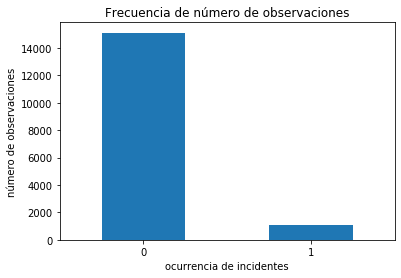

In [21]:

count_classes.plot(kind = 'bar', rot=0)
plt.xticks(range(2))
plt.title("Frecuencia de número de observaciones")
plt.xlabel("ocurrencia de incidentes")
plt.ylabel("número de observaciones")

<a id='part3'></a>
## Balanceo de datos   

##### Resampling con Smote-Tomek

técnica muy usada que consiste en aplicar en simultáneo un algoritmo de **UnderSampling** y otro de **OverSampling** a la vez al dataset. Se utilizará **SMOTE** **(Syntetic Minority Oversamplig
Technique)** para oversampling: busca puntos vecinos cercanos y agrega puntos «en linea recta» entre ellos. Y usaremos **Tomek** para undersampling que quita los de distinta clase que sean vecinos más cercanos y deja ver mejor la decisión boundary (la zona limítrofe de nuestras clases).

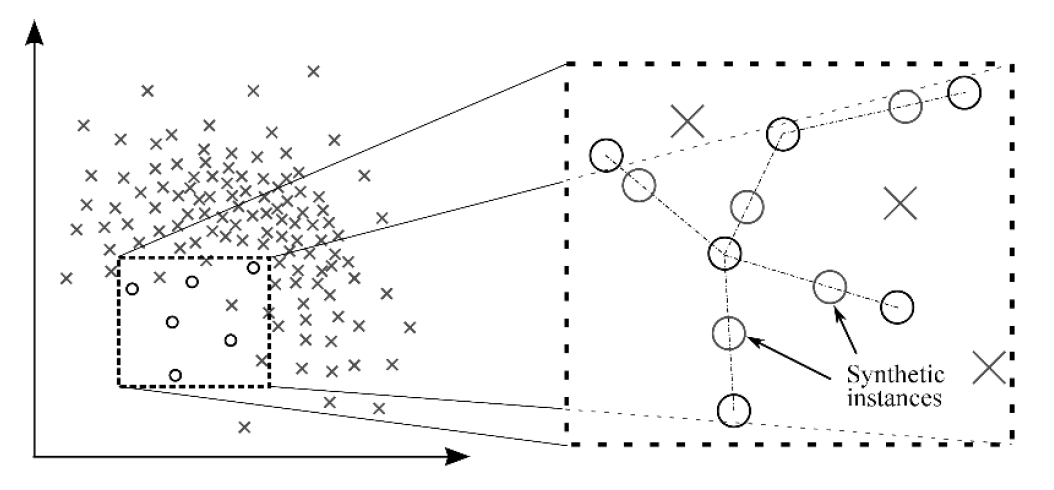

In [27]:
Image(filename='D:/Python/1. Nivel I/7/imagenes/07_03.png', width=600) 

In [28]:
os_us = SMOTETomek(ratio=0.8, random_state=2020)

##### valores balanceados

In [29]:
X_t_st, y_t_st = os_us.fit_sample(X_train, y_train)

In [30]:
#X_p_st, y_p_st = os_us.fit_sample(X_test, y_test)

##### Datos de entrenamiento

In [31]:
#Datos de entrenamiento
x_t_st= pd.DataFrame(X_t_st, columns=["rsrp", "redireccion", "cqi"])
y_t_st= pd.DataFrame(y_t_st, columns=["incidentes"])

entel_entrenamiento_smotetomek = pd.concat([x_t_st, y_t_st], axis=1)
entel_entrenamiento_smotetomek.head()

,rsrp,redireccion,cqi,incidentes
0,-118.7500,11229.222100,7.420288,0
1,-109.3750,4810.049775,8.735570,0
2,-118.5625,14817.830880,7.855299,0
3,-111.4375,374.690909,8.024744,0
4,-105.0625,771.971040,11.067591,0


Text(0, 0.5, 'número de observaciones')

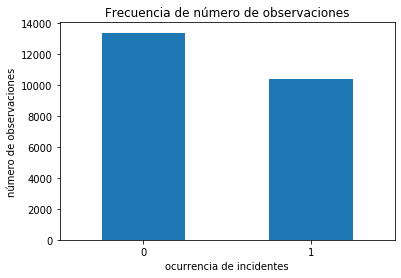

In [32]:
count_classes = pd.value_counts(entel_entrenamiento_smotetomek['incidentes'], sort = True)
count_classes.plot(kind = 'bar', rot=0)
plt.xticks(range(2))
plt.title("Frecuencia de número de observaciones")
plt.xlabel("ocurrencia de incidentes")
plt.ylabel("número de observaciones")

In [31]:
print(pd.value_counts(entel_entrenamiento_smotetomek['incidentes'], sort = True))

0    13623
1     6062
Name: incidentes, dtype: int64


In [32]:
print(entel_entrenamiento_smotetomek.shape)

(19685, 4)


<a id='part4'></a>
## Regresión Logística - Entrenamiento


In [33]:
from sklearn import datasets
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression

In [34]:
logit = LogisticRegression()

##### identificación de variables en el modelo

In [36]:
entel_vars = entel.columns.values.tolist()
entel_vars

['rsrp', 'redireccion', 'cqi', 'incidentes']

In [37]:
Y = ['incidentes'] #objeto tipo lista que guarda la etiqueta del target
Y

['incidentes']

In [38]:
X = [v for v in entel_vars if v not in Y]
X

['rsrp', 'redireccion', 'cqi']

##### recursive feature elimination (RFE) 

https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.RFE.html

In [39]:
n = 2

In [42]:
selec = RFE(logit,#modelo
            n) #número de variables a seleccionar
#fit() nos ayuda a aplicar la función selec
selec = selec.fit(entel[X], #valores de los predictores
                  entel[Y].values.ravel()) #raget

C:\Users\SOCIAL DATA\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\SOCIAL DATA\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [42]:
print(selec.support_)

[ True False  True]


In [41]:
print(selec.ranking_)

[1 2 1]


In [46]:
z=zip(entel_vars,selec.support_, selec.ranking_)

In [47]:
list(z)

[('rsrp', True, 1), ('redireccion', False, 2), ('cqi', True, 1)]

### Estimación con statsmodel

#### Estimacion del modelo con datos sin balancear

In [48]:
import statsmodels.api as sm

In [49]:
x_entel = entel[["rsrp", "cqi"]] #df de los predictores
y_entel = entel["incidentes"] #df del target

In [50]:
logit = sm.Logit(y_entel, #ingresa en formato df los valares del target
                 x_entel) #ingresa en formato df los valores de los predictores

In [51]:
result = logit.fit()

Optimization terminated successfully.
         Current function value: 0.241810
         Iterations 7


In [52]:
result.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                         Results: Logit
=================================================================
Model:              Logit            Pseudo R-squared: -0.005    
Dependent Variable: incidentes       AIC:              11177.0788
Date:               2020-09-27 15:57 BIC:              11193.1743
No. Observations:   23103            Log-Likelihood:   -5586.5   
Df Model:           1                LL-Null:          -5557.3   
Df Residuals:       23101            LLR p-value:      1.0000    
Converged:          1.0000           Scale:            1.0000    
No. Iterations:     7.0000                                       
--------------------------------------------------------------------
        Coef.     Std.Err.       z       P>|z|      [0.025    0.975]
--------------------------------------------------------------------
rsrp    0.0251      0.0013    19.4253    0.0000     0.0226    0.0276
cqi     0.0266      0.0176     1.5139    0.1301    -0.0079    0.0611
=================================================================

"""

#### Estimacion del modelo con datos balanceados

In [53]:
import statsmodels.api as sm

In [54]:
x_entel = entel_entrenamiento_smotetomek[["rsrp","cqi"]]
y_entel = entel_entrenamiento_smotetomek["incidentes"]

In [55]:
logit = sm.Logit(y_entel, x_entel)

In [56]:
result = logit.fit()

Optimization terminated successfully.
         Current function value: 0.684572
         Iterations 4


In [58]:
result.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                         Results: Logit
=================================================================
Model:              Logit            Pseudo R-squared: 0.001     
Dependent Variable: incidentes       AIC:              32563.5983
Date:               2020-09-27 15:58 BIC:              32579.7516
No. Observations:   23781            Log-Likelihood:   -16280.   
Df Model:           1                LL-Null:          -16291.   
Df Residuals:       23779            LLR p-value:      2.6756e-06
Converged:          1.0000           Scale:            1.0000    
No. Iterations:     4.0000                                       
--------------------------------------------------------------------
          Coef.     Std.Err.      z       P>|z|     [0.025    0.975]
--------------------------------------------------------------------
rsrp      0.0070      0.0007    9.9222    0.0000    0.0056    0.0084
cqi       0.0685      0.0098    7.0053    0.0000    0.0493    0.0876
=================================================================

"""

### Estimación con  scikit-learn

In [60]:
from sklearn import linear_model

In [61]:
logit_model = linear_model.LogisticRegression()
logit_model.fit(X_t_st,#valores de los predictores
                y_t_st) #valores del target

C:\Users\SOCIAL DATA\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\SOCIAL DATA\AppData\Roaming\Python\Python37\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

### Validación del modelo logístico

##### accuracy 

In [62]:
#entrenamiento 
logit_model.score(X_t_st,#los valores de los predictores de entrenamiento balanceados por smoke y tomek
                  y_t_st) #los valores del target de entrenamiento balanceado por st
#score(): función para calcular el accuracy del modelo para los datos ingresados

0.653799251503301

In [63]:
#prueba / test
logit_model.score(X_test,#los datos de testeo x
                  y_test) #los datos de testeo y

0.8195065647092772

##### Probabilidad predicha por el modelo para los datos de prueba

In [64]:
probs = logit_model.predict_proba(X_test)

In [65]:
probs

array([[0.6117005 , 0.3882995 ],
       [0.52496697, 0.47503303],
       [0.62468706, 0.37531294],
       ...,
       [0.65548728, 0.34451272],
       [0.68159481, 0.31840519],
       [0.46914098, 0.53085902]])

In [66]:
prediction = logit_model.predict(X_test)

In [67]:
prediction

array([0, 0, 0, ..., 0, 0, 1], dtype=int64)

In [107]:
prob = probs[:,1]
prob_df = pd.DataFrame(prob, columns=["Prob y=1"])
prob_df.head()

,Prob y=1
0,0.388299
1,0.475033
2,0.375313
3,0.383927
4,0.316729


In [76]:
punto_c = 0.66
prob_df["prediction"] = np.where(prob_df[0]>punto_c, 1, 0)
prob_df.head()

,0,prediction
0,0.388299,0
1,0.475033,0
2,0.375313,0
3,0.383927,0
4,0.316729,0


In [77]:
from sklearn import metrics

In [78]:
metrics.accuracy_score(y_test, 
                       prob_df["prediction"])

0.8916462270956572

### accuracy datos de entrenamiento

In [81]:
probs2 = logit_model.predict_proba(X_t_st)
prob2 = probs2[:,1]
prob_df2 = pd.DataFrame(prob2)
punto_c2 = 0.66
prob_df2["prediction"] = np.where(prob_df2[0]>punto_c2, 1, 0)
prob_df2.head()

,0,prediction
0,0.442048,0
1,0.378193,0
2,0.487759,0
3,0.323710,0
4,0.337393,0


In [82]:
from sklearn import metrics
metrics.accuracy_score(y_t_st, prob_df2["prediction"])

0.6108658172490644

##### Validación cruzada

In [84]:
from sklearn.model_selection import cross_val_score

In [85]:
scores = cross_val_score(linear_model.LogisticRegression(),#modelo
                         X_t_st, #xs
                         y_t_st, #y
                         scoring="accuracy", #métrica 
                         cv=100) #particiones de la data

C:\Users\SOCIAL DATA\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\SOCIAL DATA\AppData\Roaming\Python\Python37\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\SOCIAL DATA\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\SOCIAL DATA\AppData\Roaming\Python\Python37\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using rave

In [86]:
scores

array([0.68200837, 0.62343096, 0.64016736, 0.65966387, 0.67226891,
       0.62605042, 0.64705882, 0.67226891, 0.62605042, 0.64285714,
       0.67226891, 0.67226891, 0.62605042, 0.62605042, 0.64705882,
       0.64705882, 0.68067227, 0.57563025, 0.6302521 , 0.6092437 ,
       0.69747899, 0.68487395, 0.67226891, 0.64285714, 0.65966387,
       0.64285714, 0.62605042, 0.59663866, 0.65546218, 0.65546218,
       0.69327731, 0.64285714, 0.67226891, 0.67647059, 0.63445378,
       0.63445378, 0.64285714, 0.6512605 , 0.66386555, 0.68067227,
       0.64285714, 0.68067227, 0.64705882, 0.63865546, 0.69747899,
       0.63865546, 0.63445378, 0.68487395, 0.65546218, 0.68487395,
       0.65546218, 0.61344538, 0.64285714, 0.62605042, 0.71008403,
       0.6302521 , 0.65546218, 0.66806723, 0.67226891, 0.63865546,
       0.67226891, 0.65966387, 0.69747899, 0.62605042, 0.6512605 ,
       0.61764706, 0.64285714, 0.63445378, 0.64705882, 0.70168067,
       0.68487395, 0.65966387, 0.68907563, 0.64285714, 0.67226

In [87]:
scores.mean()

0.6538860921202336

##### Matrices de Confusión

In [93]:
confusion_matrix = pd.crosstab(y_test, prob_df["prediction"])
confusion_matrix

prediction,0,1
row_0,,
0,6107,373
1,378,73


In [90]:
type(confusion_matrix)

pandas.core.frame.DataFrame

In [94]:
VN=confusion_matrix[1][1]
VP=confusion_matrix[0][0]
FP=confusion_matrix[0][1]
FN=confusion_matrix[1][0]

In [95]:
confusion_matrix[0][0] 

6107

In [96]:
VN

73

In [97]:
VP

6107

In [98]:
FN

373

In [99]:
FP

378

In [100]:
sens = VP/(VP+FN)
sens

0.9424382716049383

In [101]:
espc = VN/(VN+FP)
espc

0.16186252771618626

In [102]:
espc_1 = 1-espc
espc_1

0.8381374722838137

##### Curvas ROC

In [103]:
import matplotlib.pyplot as plt

Text(0.5, 1.0, 'Curva ROC')

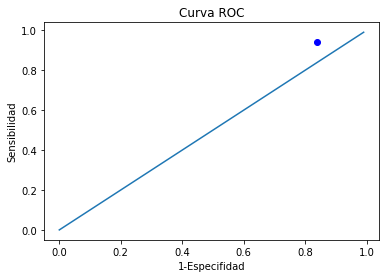

In [104]:
%matplotlib inline
plt.plot(espc_1, 
         sens, 
         marker="o", 
         linestyle="--", 
         color="b")
x=[i*0.01 for i in range(100)]
y=[i*0.01 for i in range(100)]
plt.plot(x,y)
plt.xlabel("1-Especifidad")
plt.ylabel("Sensibilidad")
plt.title("Curva ROC")


____
[Ir a inicio](#beginning)

## Caso practico

In [133]:
import pandas as pd
import numpy as np

In [137]:
df_fraude = pd.read_csv('D:/SOCIAL DATA/Dropbox/Python 5ta edición - Programa Completo/2. intermedio/sesión_4/datos/creditcard.csv',  sep=',')
df_fraude.info()
df_fraude.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
Time      284807 non-null float64
V1        284807 non-null float64
V2        284807 non-null float64
V3        284807 non-null float64
V4        284807 non-null float64
V5        284807 non-null float64
V6        284807 non-null float64
V7        284807 non-null float64
V8        284807 non-null float64
V9        284807 non-null float64
V10       284807 non-null float64
V11       284807 non-null float64
V12       284807 non-null float64
V13       284807 non-null float64
V14       284807 non-null float64
V15       284807 non-null float64
V16       284807 non-null float64
V17       284807 non-null float64
V18       284807 non-null float64
V19       284807 non-null float64
V20       284807 non-null float64
V21       284807 non-null float64
V22       284807 non-null float64
V23       284807 non-null float64
V24       284807 non-null float64
V25       284807 non-null float64
V26  

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,'0'
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,'0'
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,'0'
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,'0'
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,'0'


Actividades:

1. Asignar el 60% y 40% a la data de entrenamiento y testeo respectivamente.
2. Crear un dataframe a partir de la data de entrenamiento con la tecnica de balanceo de datos "UnderSampling" y parámetro de balanceo 0.7.
3. Utilizar esa data balanceada para aplicar un modelo de regresión logística utilizando sólo 6 variables predictoras (utilice recursive feature elimination (RFE)) y tener en cuenta que el TARGET es Class

enviar: msiguenas@socialdata-peru.com

asunto: LABORATORIO REGRESIÓN LOGÍSTICA

____
[Ir a inicio](#beginning)